In [3]:


import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(10)
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCH = 2
past_history = 4 * 24 * 10
future_target = 4 * 24
STEP = 4
SHIFT_STEP = 1

In [16]:
def root_mean_squared_error_loss(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.losses.MSE(y_true, y_pred))


tf.random.set_seed(10)
raw_df = pd.read_csv("../../data/datefrom1st_revised.csv")
raw_df.index = raw_df.datetime

df = raw_df

df = df.drop(
    ["Unnamed: 0", 'datetime', 'percipitation', 'air_pressure', 'sea_level_pressure',
     'wind_degree'], axis=1)
df["difference"] = df.astype('int32')

scaler = MinMaxScaler().fit(df)
target_X = df.loc["2020-01-31 00:00:00":"2020-01-31 23:45:00"]


df.drop(df.loc[(df.index > '2020-01-31 00:00:00') & (df.index < '2020-02-01 00:00:00')].index, inplace=True)
df.drop(df.loc[(df.index > '2020-03-31 00:00:00') & (df.index < '2020-04-01 00:00:00')].index, inplace=True)
df.drop(df.loc[(df.index > '2020-05-31 00:00:00') & (df.index < '2020-06-01 00:00:00')].index, inplace=True)
df = df.fillna(0)

In [17]:
target_X
#

,result,temperature,wind_speed,humidity,solar_radiation,solar_intensity,difference
datetime,,,,,,,
2020-01-31 00:00:00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
2020-01-31 00:15:00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
2020-01-31 00:30:00,0.0,4.866667,1.500000,59.900000,0.0,0.0,0
2020-01-31 00:45:00,0.0,4.673333,1.553333,61.546667,0.0,0.0,0
2020-01-31 01:00:00,0.0,4.446667,1.346667,62.140000,0.0,0.0,0
...,...,...,...,...,...,...,...
2020-01-31 22:45:00,0.0,2.140000,0.340000,64.766667,0.0,0.0,0
2020-01-31 23:00:00,0.0,2.186667,0.606667,64.786667,0.0,0.0,0
2020-01-31 23:15:00,0.0,2.160000,0.626667,64.766667,0.0,0.0,0


In [18]:
TRAIN_SPLIT = int(len(df.index) * 0.8)

values = scaler.transform(df)
target_X = scaler.transform(target_X)

In [19]:
train = values[:TRAIN_SPLIT, :]
test = values[TRAIN_SPLIT:, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
target_X = target_X[:, 1:]

In [20]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
target_X = target_X.reshape((target_X.shape[0], 1, target_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(target_X.shape)

(27880, 1, 6) (27880,) (6971, 1, 6) (6971,)
(96, 1, 6)


In [21]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


In [22]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel('Time-Step')
    return plt


def create_time_steps(length):
    return list(range(-length, 0))


In [23]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out) / STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out) / STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    plt.savefig("output.png")


In [24]:
def fit_by_batch(X, y, batch_size):
    n_batches_for_epoch = X.shape[0]//batch_size
    for i in range(n_batches_for_epoch):
        index_batch = range(X.shape[0])[batch_size*i:batch_size*(i+1)]
        X_batch =X[index_batch][0].toarray()[0] #from sparse to array
        X_batch=X_batch.reshape(1,X_batch.shape[0],1 ) # to 3d array
        y_batch = y[index_batch,][0]
        yield(np.array(X_batch),y_batch)


import tensorflow as tf
from tensorflow.keras.layers import RepeatVector

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.GRU(300, 
                                          return_sequences=True,
                                          input_shape=(train_X.shape[1], train_X.shape[2])))
multi_step_model.add(tf.keras.layers.ReLU())
multi_step_model.add(tf.keras.layers.Dense(300))
multi_step_model.add(tf.keras.layers.LeakyReLU())
multi_step_model.add(tf.keras.layers.Dense(1))

In [25]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 300)            277200    
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 300)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 300)            90300     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 300)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              301       
Total params: 367,801
Trainable params: 367,801
Non-trainable params: 0
_________________________________________________________________


[+] Available GPUs
[]
[+] Available multiple GPU not found... Just use CPU! XD
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00011, saving model to ../23_checkpoint.keras
109/109 - 1s - loss: 0.0040 - val_loss: 1.0777e-04 - lr: 0.0010
Epoch 2/2

Epoch 00002: val_loss improved from 0.00011 to 0.00007, saving model to ../23_checkpoint.keras

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
109/109 - 1s - loss: 6.7761e-05 - val_loss: 6.6739e-05 - lr: 0.0010


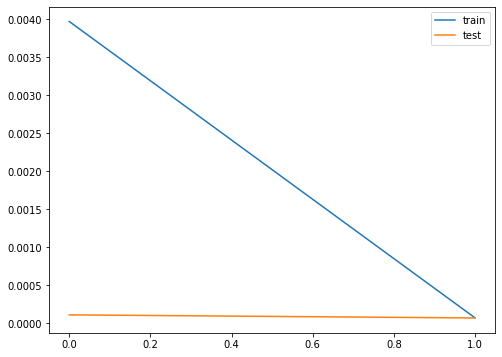

<Figure size 576x432 with 0 Axes>

In [26]:
from matplotlib import pyplot
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

EVALUATION_INTERVAL = 200


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


def get_gpu_num():
    return len(get_available_gpus())


path_checkpoint = '../23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1)

callback_tensorboard = TensorBoard(log_dir='../23_logs/', histogram_freq=0, write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=0,verbose=1)
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

print(f"[+] Available GPUs")
print(get_available_gpus())

if get_gpu_num() < 2:
    print(f"[+] Available multiple GPU not found... Just use CPU! XD")
else:
    print(f"[+] {get_gpu_num()} GPUs found! Setting to GPU model...")
    multi_step_model = multi_gpu_model(multi_step_model, gpus=get_gpu_num())

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

history = multi_step_model.fit(train_X, train_y, epochs=EPOCH, batch_size=32 * 8,validation_data=(test_X, test_y),
                               verbose=2, shuffle=True, callbacks=callbacks)

try:
    multi_step_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig("test.png")

In [27]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = multi_step_model.predict(target_X)[:,:,0]
print(yhat)
# make a prediction
target_X = target_X.reshape((target_X.shape[0], target_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, target_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
print(inv_yhat)
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, 0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.6f' % rmse)
# print('Test MAE: %.6f' % mean_squared_error(inv_y, inv_yhat))
# print('Test nMAE: %.6f' % (mean_squared_error(inv_y, inv_yhat) / 7028))
# 
# pyplot.plot([x for x in range(1000)], inv_y[-1000:], 'b', label='true')
# pyplot.plot([x for x in range(1000)], inv_yhat[-1000:], 'r', label='pred')
# pyplot.legend(loc='upper left')
# pyplot.savefig("out.png")

[[-4.85738507e-04]
 [-4.85738507e-04]
 [-9.93657159e-04]
 [-9.63928644e-04]
 [-1.34572014e-03]
 [-1.47518096e-03]
 [-1.58069865e-03]
 [-1.79090770e-03]
 [-2.06031115e-03]
 [-1.74118811e-03]
 [-1.57778873e-03]
 [-1.41168130e-03]
 [-1.28689874e-03]
 [-1.39186415e-03]
 [-1.03882095e-03]
 [-9.99687705e-04]
 [-1.63619546e-03]
 [-1.80185935e-03]
 [-1.43843307e-03]
 [-6.21350016e-04]
 [-4.19319142e-04]
 [-1.56353693e-04]
 [-2.53828708e-04]
 [-2.57730833e-04]
 [-8.05371441e-04]
 [ 1.42735429e-04]
 [-6.45006774e-04]
 [-8.52301717e-04]
 [-1.47897843e-03]
 [-2.84853857e-04]
 [ 5.84702939e-05]
 [ 2.43639690e-04]
 [-6.84435945e-05]
 [ 2.90639931e-03]
 [ 6.17061136e-03]
 [ 8.06018338e-03]
 [ 1.05530117e-02]
 [ 1.30457506e-02]
 [ 1.79918241e-02]
 [ 2.03412715e-02]
 [ 1.98797993e-02]
 [ 2.15829611e-02]
 [ 2.40969770e-02]
 [ 2.63481252e-02]
 [ 2.49554552e-02]
 [ 2.54603121e-02]
 [ 2.58279108e-02]
 [ 2.74250992e-02]
 [ 2.81639416e-02]
 [ 2.98189092e-02]
 [ 3.02968286e-02]
 [ 3.10742948e-02]
 [ 3.1678758